In [1]:
%load_ext autoreload
%autoreload 2

from utils.preprocessing import create_time_matrix, create_caregivers_df, create_tasks_df, create_clients_df, create_continuity_df

caregivers = create_caregivers_df('data/raw/caregivers.csv')

tasks = create_tasks_df('data/raw/hemtjanst_tasks.csv', only_client_tasks=True)

clients = create_clients_df('data/raw/clients.csv')

drive_time_matrix = create_time_matrix('data/raw/duration_matrix_DRIVE.csv')
walk_time_matrix = create_time_matrix('data/raw/duration_matrix_WALK.csv')
bicycle_time_matrix = create_time_matrix('data/raw/duration_matrix_BICYCLE.csv')

continuity = create_continuity_df('data/raw/continuity.csv')

In [6]:
# Test1: Subset with only caregivers 33, 949, 1108 and their tasks
test1_subset = [33, 949, 1108]
test_caregivers = caregivers.loc[test1_subset]
test_tasks = tasks[tasks['PlannedCaregiverID'].isin(test1_subset)]
small_test = (test_caregivers, test_tasks)

# Test2: Subset with only first 10 caregivers that use car as mode of transport
car_caregivers = caregivers[caregivers['ModeOfTransport'] == 'car'].head(10)
car_tasks = tasks[tasks['PlannedCaregiverID'].isin(car_caregivers.index)]
car_test = (car_caregivers, car_tasks)

full_test = (caregivers, tasks)

In [25]:
from models.fixed_model import FixedModel
from models.tsp_model import TSPModel
model_type = FixedModel
model_caregivers, model_tasks = car_test

model = model_type(model_caregivers, model_tasks, clients, drive_time_matrix, walk_time_matrix, bicycle_time_matrix, continuity)
model.build(
        caregiver_penalty=100,
        overtime_penalty=3,
        # worktime_per_break=0,
        # continuity_penalty=0,
        
)
model.optimize(
    # NoRelHeurWork=120, 
    # Heuristics=0.2, 
    # MIPFocus=1
)

Created base variables.
Built base model.
Adding overtime penalties.
Adding caregiver usage penalties.
Adding break requirements.
Adding continuity of care penalties.
Updated objective function with penalties.
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2852 rows, 83830 columns and 409100 nonzeros
Model fingerprint: 0x10fa7a1b
Variable types: 30 continuous, 83800 integer (83800 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 202 rows and 47455 columns
Presolve time: 0.27s
Presolved: 2650 rows, 36375 columns, 162584 nonzeros
Variable types: 20 continuous, 36355 integer (36345 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 

<gurobi.Model MIP instance HomeCare: 2852 constrs, 83830 vars, Parameter changes: Username=(user-defined), LicenseID=2634432>

Model not optimally solved. Status: 11

                              HOME CARE SCHEDULE METRICS SUMMARY

SCHEDULE OVERVIEW:
  Total tasks:              90
  Active caregivers:        10/10

TIME ALLOCATION:
  Service time:             2920 min (68.1%)
  Travel time:              562 min (13.1%)
  Waiting time:             505 min (11.8%)
  Break time:               300 min (7.0%)
  Total schedule time:      4287 min

CONTINUITY METRICS:
  Historical visits:        55/90 (61.1%)
  Avg caregivers per client: 1.4
  Historical continuity:    61.1%
  Perfect continuity:       24 clients
  Perfect historical:       21 clients

AVERAGE PER CAREGIVER:
  Tasks:                    9.0
  Service time:             292 min
  Travel time:              56 min
  Waiting time:             51 min
  Break time:               30 min
  Utilization:              68.1%



<string>:246: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


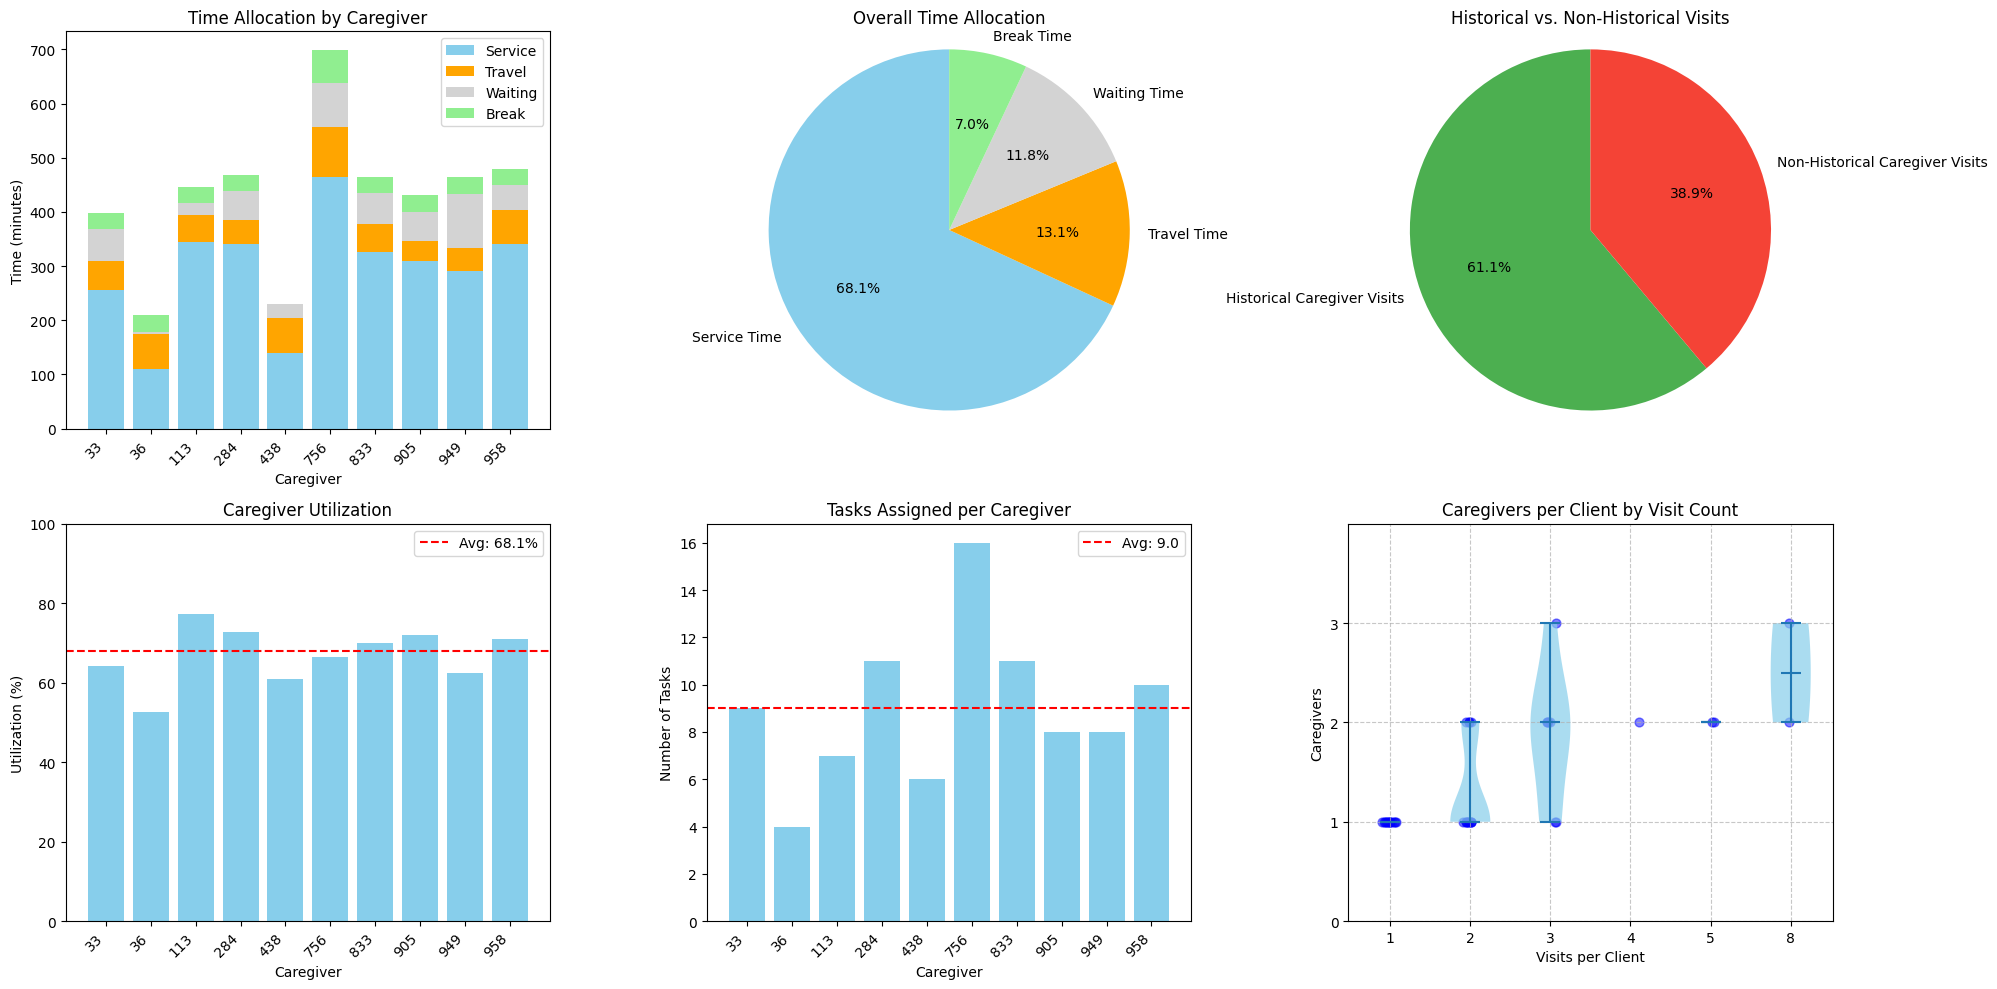

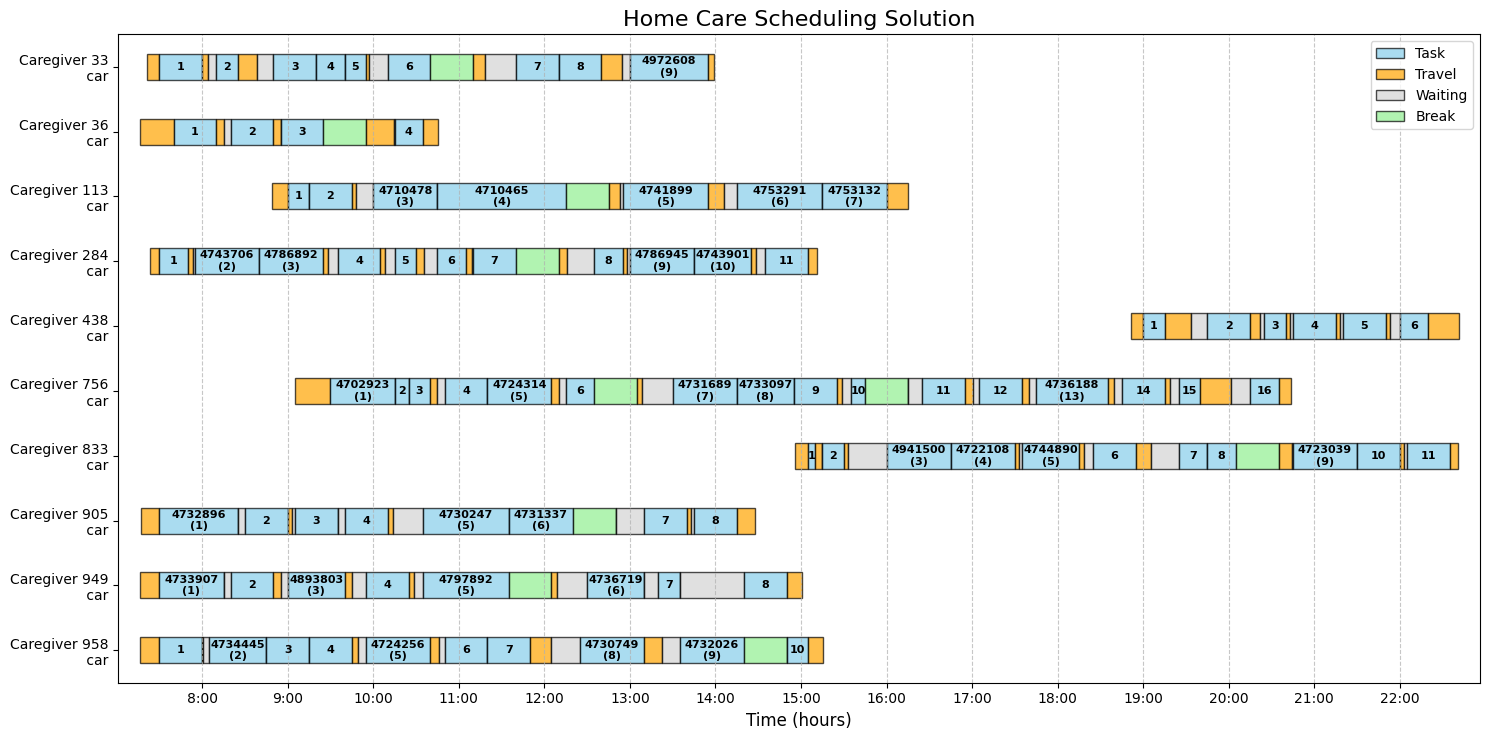

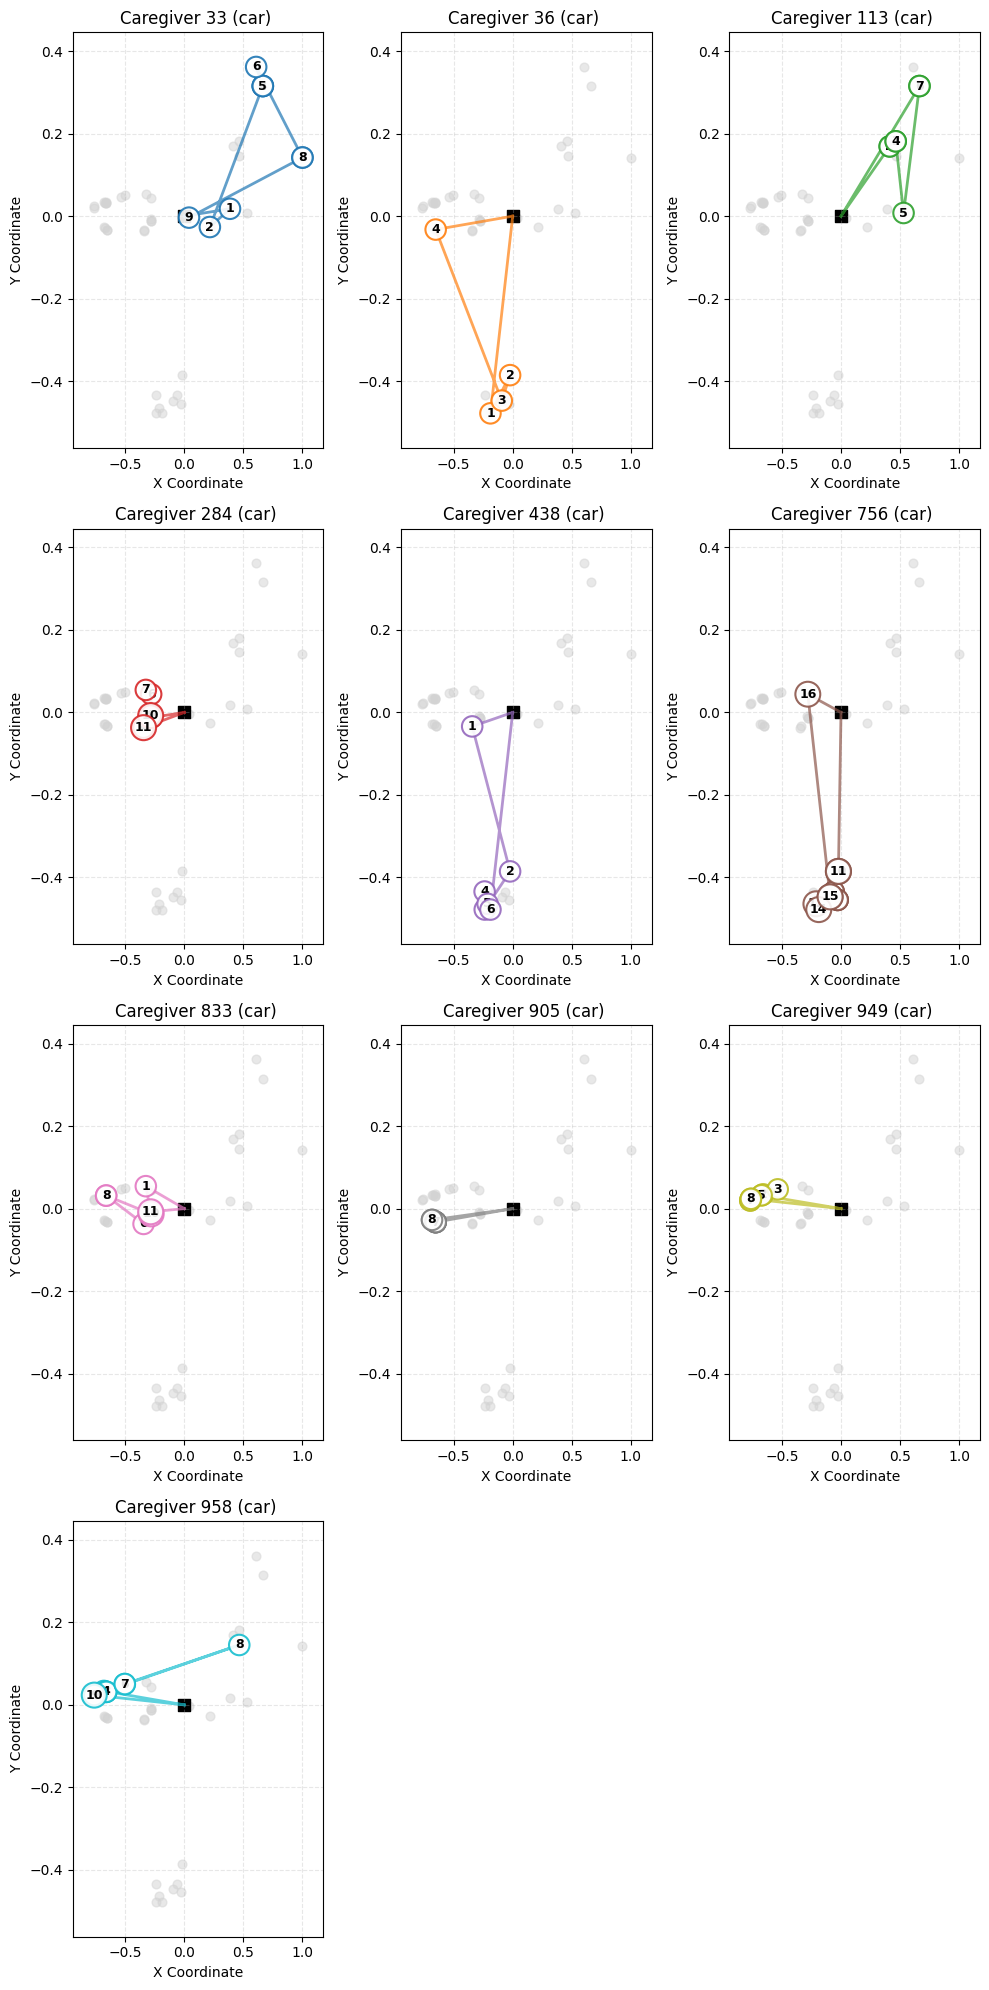

In [ ]:
from utils.visualization import visualize_schedule, visualize_metrics, visualize_routes, display_metrics_summary

model.get_solution()

#display_metrics_summary(model)
visualize_metrics(model, display_mode='dashboard');
visualize_schedule(model);
visualize_routes(model, caregiver_ids=None, subplot_mode=True);

In [35]:
from utils.solution_storage import save_solution
save_solution(model, 'full_test_first_draft')

Solution saved to data/saved_solutions/20250331_081731_full_test_first_draft.json


'data/saved_solutions/20250331_081731_full_test_first_draft.json'